# Datenanalyse mit neuen Daten am 12.05.

False Positives

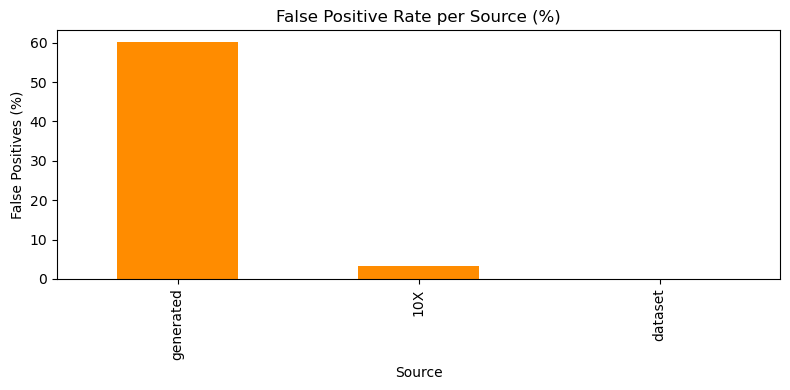

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Einlesen
fp = pd.read_csv("../../results/false_positives_v2.csv", sep="\t")
test_path  = '../../../../data/splitted_datasets/allele/beta/new/test.tsv'
test_df  = pd.read_csv(test_path, sep='\t')

# Gesamtanzahl pro Quelle im gesamten Testset
total_per_source = test_df["source"].value_counts()

# Anzahl der False Positives pro Quelle
fp_per_source = fp["source"].value_counts()

# Prozentuale False Positive Rate pro Quelle
fp_rate_per_source = (fp_per_source / total_per_source * 100).sort_values(ascending=False)

# Plot
plt.figure(figsize=(8, 4))
fp_rate_per_source.plot(kind="bar", color="darkorange")
plt.title("False Positive Rate per Source (%)")
plt.ylabel("False Positives (%)")
plt.xlabel("Source")
plt.tight_layout()
plt.show()

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# CSV einlesen
fp = pd.read_csv("../../results/false_positives_v2.csv", sep="\t")

# Nur TPP1-Fehlklassifikationen
fp_tpp1 = fp[fp["task"] == "TPP1"].copy()
print(f"Anzahl TPP1 False Positives: {len(fp_tpp1)}")

# Nur TPP2-Fehlklassifikationen
fp_tpp2 = fp[fp["task"] == "TPP2"].copy()
print(f"Anzahl TPP2 False Positives: {len(fp_tpp2)}")

# Nur TPP3-Fehlklassifikationen
fp_tpp3 = fp[fp["task"] == "TPP3"].copy()
print(f"Anzahl TPP3 False Positives: {len(fp_tpp3)}")

# Nur TPP4-Fehlklassifikationen
fp_tpp4 = fp[fp["task"] == "TPP4"].copy()
print(f"Anzahl TPP4 False Positives: {len(fp_tpp4)}")

# Top Epitope bei FPs
top_epitopes = fp_tpp2["Epitope"].value_counts().head(10)
print("\nTop Epitope unter TPP2-False-Positives:\n", top_epitopes)


Anzahl TPP1 False Positives: 965
Anzahl TPP2 False Positives: 15301
Anzahl TPP3 False Positives: 2503
Anzahl TPP4 False Positives: 455

Top Epitope unter TPP2-False-Positives:
 Epitope
CINGVCWTV     2150
ELAGIGILTV    1465
GTSGSPIINR    1351
GTSGSPIVNR    1303
GLCTLVAML     1188
GILGFVFTL      868
AVFDRKSDAK     809
KRWIILGLNK     700
EIYKRWII       654
FLKEKGGL       584
Name: count, dtype: int64


=== False Positives → max‐Similarity zu echten Positiven desselben TCR ===
count    18062.000000
mean         0.542957
std          0.052817
min          0.230769
25%          0.500000
50%          0.529412
75%          0.578947
max          0.750000
Name: max_pos_sim, dtype: float64


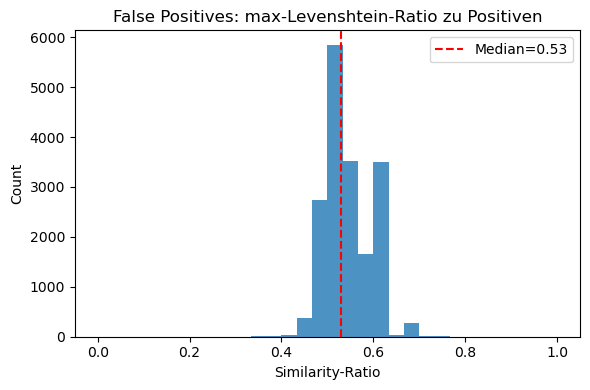

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) False Positives einlesen
fp = pd.read_csv("../../results/false_positives_v2.csv", sep="\t")

# 2) Splits einlesen und positive Epitopen pro TCR mappen
BASE = "../../../../data/splitted_datasets/allele/beta/new"
train = pd.read_csv(f"{BASE}/train.tsv",      sep="\t", dtype=str)
val   = pd.read_csv(f"{BASE}/validation.tsv", sep="\t", dtype=str)
test  = pd.read_csv(f"{BASE}/test.tsv",       sep="\t", dtype=str)
for df in (train, val, test):
    df["Binding"] = df["Binding"].astype(int)

# positives Set pro TCR
pos_train = train [train["Binding"]==1].groupby("TRB_CDR3")["Epitope"].apply(set)
pos_val   = val   [val  ["Binding"]==1].groupby("TRB_CDR3")["Epitope"].apply(set)
pos_test  = test  [test ["Binding"]==1].groupby("TRB_CDR3")["Epitope"].apply(set)
tcr_to_pos = { **pos_train.to_dict(),
               **pos_val.to_dict(),
               **pos_test.to_dict() }

# 3) Levenshtein-Ratio-Funktion
def levenshtein(a, b):
    if len(a)<len(b): return levenshtein(b,a)
    prev = list(range(len(b)+1))
    for i, ca in enumerate(a,1):
        curr = [i]
        for j, cb in enumerate(b,1):
            curr.append(min(prev[j]+1, curr[j-1]+1, prev[j-1]+(ca!=cb)))
        prev = curr
    return prev[-1]

def ratio(a,b):
    d = levenshtein(a,b)
    return (len(a)+len(b)-d)/(len(a)+len(b))

# 4) max‐Ratio gegen die echten Positiven desselben TCR
def max_sim_to_positives(row):
    tcr  = row["TRB_CDR3"]
    epi  = row["Epitope"]
    poss = tcr_to_pos.get(tcr, ())
    if not poss:
        return np.nan
    return max(ratio(epi, p) for p in poss)

# 5) Anwenden & Auswerten
fp["max_pos_sim"] = fp.apply(max_sim_to_positives, axis=1)

print("=== False Positives → max‐Similarity zu echten Positiven desselben TCR ===")
print(fp["max_pos_sim"].describe())

# Histogramm
plt.figure(figsize=(6,4))
plt.hist(fp["max_pos_sim"].dropna(), bins=30, range=(0,1), alpha=0.8)
plt.axvline(fp["max_pos_sim"].median(), color="red", linestyle="--",
            label=f"Median={fp['max_pos_sim'].median():.2f}")
plt.title("False Positives: max-Levenshtein-Ratio zu Positiven")
plt.xlabel("Similarity-Ratio")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) False Positives laden
fp = pd.read_csv("../../results/false_positives_v2.csv", sep="\t")

# 2) Splits laden & echte Positive (Binding==1) pro Split sammeln
BASE = "../../../../data/splitted_datasets/allele/beta/new"
train = pd.read_csv(f"{BASE}/train.tsv",      sep="\t", dtype=str)
val   = pd.read_csv(f"{BASE}/validation.tsv", sep="\t", dtype=str)
test  = pd.read_csv(f"{BASE}/test.tsv",       sep="\t", dtype=str)
for df in (train, val, test):
    df["Binding"] = df["Binding"].astype(int)

pos_train = train [train["Binding"]==1].groupby("TRB_CDR3")["Epitope"].apply(set)
pos_val   = val   [val  ["Binding"]==1].groupby("TRB_CDR3")["Epitope"].apply(set)
pos_test  = test  [test ["Binding"]==1].groupby("TRB_CDR3")["Epitope"].apply(set)

# 3) Levenshtein-Ratio
def levenshtein(a, b):
    if len(a) < len(b): return levenshtein(b, a)
    prev = list(range(len(b)+1))
    for i, ca in enumerate(a,1):
        curr = [i]
        for j, cb in enumerate(b,1):
            curr.append(min(prev[j]+1, curr[j-1]+1, prev[j-1]+(ca!=cb)))
        prev = curr
    return prev[-1]

def ratio(a,b):
    d = levenshtein(a,b)
    return (len(a)+len(b)-d)/(len(a)+len(b))

# 4) Funktion: max‐Similarity gegenüber einem bestimmten Positiv-Set
def max_sim_set(row, pos_dict):
    tcr = row["TRB_CDR3"]
    epi = row["Epitope"]
    poss = pos_dict.get(tcr, ())
    if not poss:
        return np.nan
    return max(ratio(epi, p) for p in poss)

# 5) Drei neue Spalten berechnen
fp["sim_train_pos"] = fp.apply(lambda r: max_sim_set(r, pos_train.to_dict()), axis=1)
fp["sim_val_pos"]   = fp.apply(lambda r: max_sim_set(r, pos_val.to_dict()),   axis=1)
fp["sim_test_pos"]  = fp.apply(lambda r: max_sim_set(r, pos_test.to_dict()),  axis=1)

# 6) Statistiken drucken
print("=== False Positives: max‐Similarity zu Positiven pro Split ===")
for col in ["sim_train_pos","sim_val_pos","sim_test_pos"]:
    print(f"\n{col}:\n{fp[col].describe()}")

# 7) Histogramme plotten
plt.figure(figsize=(12,3))
for i, col in enumerate(["sim_train_pos","sim_val_pos","sim_test_pos"], 1):
    plt.subplot(1,3,i)
    fp[col].hist(bins=25, range=(0,1), alpha=0.8)
    plt.title(col.replace("_"," "))
    plt.xlabel("Levenshtein-Ratio")
    plt.ylabel("Count")
plt.tight_layout()
plt.suptitle("False Positives – max‐Similarity zu Positiven", y=1.02)
plt.show()


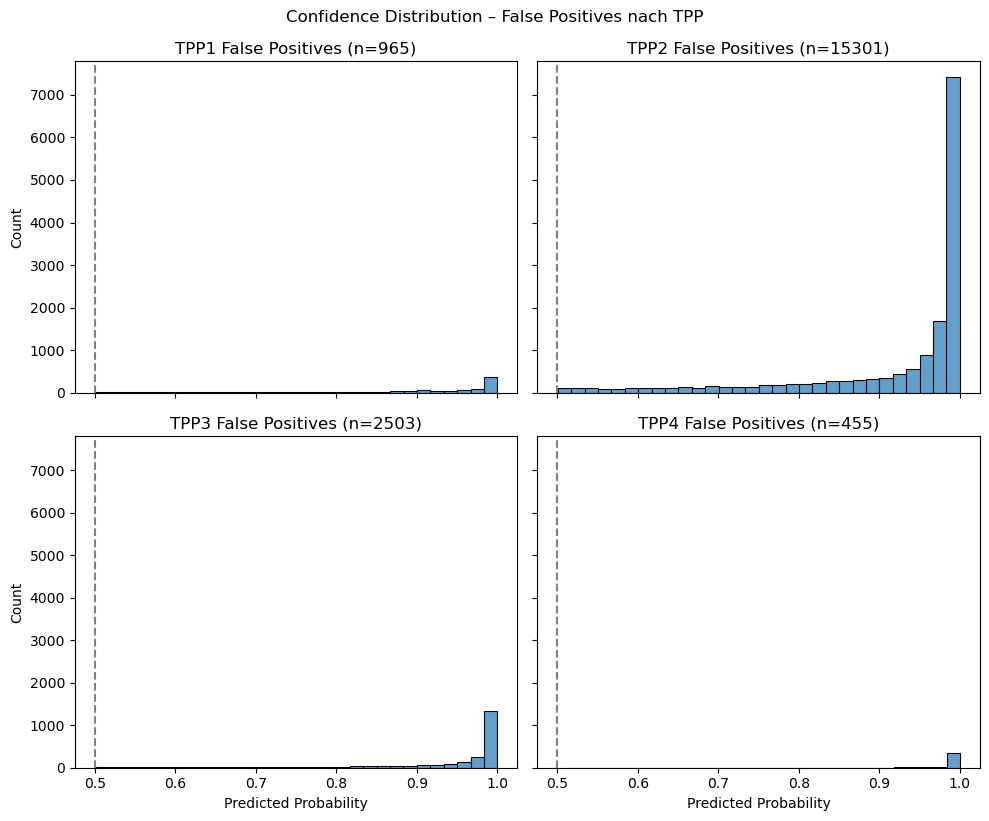

In [19]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) False Positives einlesen
fp = pd.read_csv("../../results/false_positives_v2.csv", sep="\t")

# 2) Output-Ordner sicherstellen
os.makedirs("results", exist_ok=True)

# 3) 2×2 Subplots anlegen
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
axes = axes.flatten()

# 4) Schleife über TPP1–TPP4
for idx, tpp in enumerate(["TPP1","TPP2","TPP3","TPP4"]):
    ax = axes[idx]
    sub = fp[fp["task"] == tpp]
    
    sns.histplot(
        sub["predicted_score"],
        bins=30,
        ax=ax,
        edgecolor="black",
        alpha=0.7
    )
    ax.axvline(0.5, linestyle="--", color="gray")
    ax.set_title(f"{tpp} False Positives (n={len(sub)})")
    ax.set_xlabel("Predicted Probability")
    ax.set_ylabel("Count")

# 5) Layout anpassen
plt.tight_layout()
plt.suptitle("Confidence Distribution – False Positives nach TPP", y=1.02)
plt.show()


In [26]:
import pandas as pd

# 1) False Positives einlesen
fp = pd.read_csv("../../results/false_positives_v2.csv", sep="\t", dtype=str)

# 2) Funktion zur Anzeige von Missing/Empty pro Spalte
def report_missing(df, name):
    total = len(df)
    print(f"\n== {name} ({total} Zeilen) ==")
    for col in ["TRBJ", "TRBV", "MHC"]:
        if col not in df.columns:
            print(f"Spalte {col} nicht gefunden.")
            continue
        missing = df[col].isna().sum()
        empty   = (df[col] == "").sum()
        print(f" {col}: missing={missing} ({missing/total:.2%}), empty={empty} ({empty/total:.2%})")

# 3) Reports ausgeben
report_missing(fp, "False Positives")



== False Positives (19224 Zeilen) ==
 TRBJ: missing=18 (0.09%), empty=0 (0.00%)
 TRBV: missing=12 (0.06%), empty=0 (0.00%)
 MHC: missing=53 (0.28%), empty=0 (0.00%)


# False Negatives

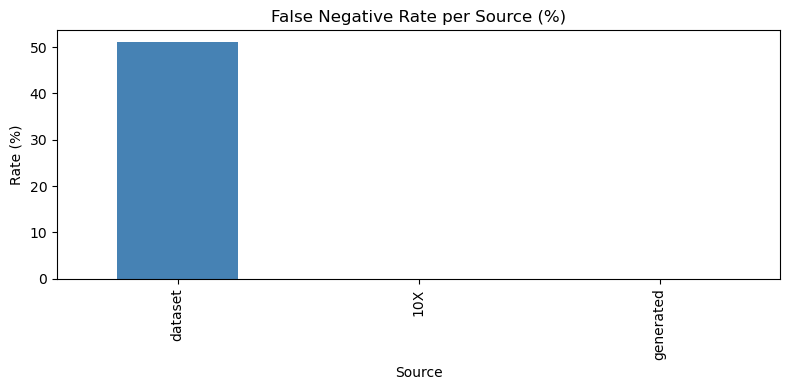

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Pfad
fn_path = "../../results/false_negatives_v2.csv"
test_path  = '../../../../data/splitted_datasets/allele/beta/new/test.tsv'
test_df  = pd.read_csv(test_path, sep='\t')

# Einlesen
fn = pd.read_csv(fn_path, sep="\t")
test_df = pd.read_csv(test_path, sep="\t")

# 1) Gesamtanzahl pro Quelle im gesamten Testset
total_per_source = test_df["source"].value_counts()

# 2) Anzahl der False Negatives pro Quelle
fn_per_source = fn["source"].value_counts()

# 3) Prozentuale False Negative Rate pro Quelle
fn_rate_per_source = (fn_per_source / total_per_source * 100).sort_values(ascending=False)

# 5) Plot False Negatives
plt.figure(figsize=(8, 4))
fn_rate_per_source.plot(kind="bar", color="steelblue")
plt.title("False Negative Rate per Source (%)")
plt.ylabel("Rate (%)")
plt.xlabel("Source")
plt.tight_layout()
plt.show()


=== False Negatives → max‐Similarity zu echten Negativen desselben TCR ===
count    4070.000000
mean        0.608388
std         0.040398
min         0.476190
25%         0.578947
50%         0.631579
75%         0.631579
max         0.736842
Name: max_neg_sim, dtype: float64


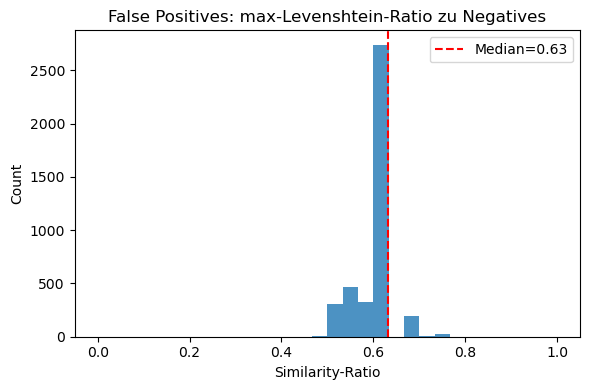

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) False Neagatives einlesen
fp = pd.read_csv("../../results/false_negatives_v2.csv", sep="\t")

# 2) Splits einlesen und negativen Epitopen pro TCR mappen
BASE = "../../../../data/splitted_datasets/allele/beta/new"
train = pd.read_csv(f"{BASE}/train.tsv",      sep="\t", dtype=str)
val   = pd.read_csv(f"{BASE}/validation.tsv", sep="\t", dtype=str)
test  = pd.read_csv(f"{BASE}/test.tsv",       sep="\t", dtype=str)
for df in (train, val, test):
    df["Binding"] = df["Binding"].astype(int)

# negative Set pro TCR
neg_train = train [train["Binding"]==0].groupby("TRB_CDR3")["Epitope"].apply(set)
neg_val   = val   [val  ["Binding"]==0].groupby("TRB_CDR3")["Epitope"].apply(set)
neg_test  = test  [test ["Binding"]==0].groupby("TRB_CDR3")["Epitope"].apply(set)
tcr_to_neg = { **neg_train.to_dict(),
               **neg_val.to_dict(),
               **neg_test.to_dict() }

# 3) Levenshtein-Ratio-Funktion
def levenshtein(a, b):
    if len(a)<len(b): return levenshtein(b,a)
    prev = list(range(len(b)+1))
    for i, ca in enumerate(a,1):
        curr = [i]
        for j, cb in enumerate(b,1):
            curr.append(min(prev[j]+1, curr[j-1]+1, prev[j-1]+(ca!=cb)))
        prev = curr
    return prev[-1]

def ratio(a,b):
    d = levenshtein(a,b)
    return (len(a)+len(b)-d)/(len(a)+len(b))

# 4) max‐Ratio gegen die echten Negativen desselben TCR
def max_sim_to_negatives(row):
    tcr  = row["TRB_CDR3"]
    epi  = row["Epitope"]
    neg = tcr_to_neg.get(tcr, ())
    if not neg:
        return np.nan
    return max(ratio(epi, p) for p in neg)

# 5) Anwenden & Auswerten
fp["max_neg_sim"] = fp.apply(max_sim_to_negatives, axis=1)

print("=== False Negatives → max‐Similarity zu echten Negativen desselben TCR ===")
print(fp["max_neg_sim"].describe())

# Histogramm
plt.figure(figsize=(6,4))
plt.hist(fp["max_neg_sim"].dropna(), bins=30, range=(0,1), alpha=0.8)
plt.axvline(fp["max_neg_sim"].median(), color="red", linestyle="--",
            label=f"Median={fp['max_neg_sim'].median():.2f}")
plt.title("False Positives: max-Levenshtein-Ratio zu Negatives")
plt.xlabel("Similarity-Ratio")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()


=== False Negatives: max‐Similarity zu Negativen pro Split ===

sim_train_neg:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: sim_train_neg, dtype: float64

sim_val_neg:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: sim_val_neg, dtype: float64

sim_test_neg:
count    4070.000000
mean        0.608388
std         0.040398
min         0.476190
25%         0.578947
50%         0.631579
75%         0.631579
max         0.736842
Name: sim_test_neg, dtype: float64


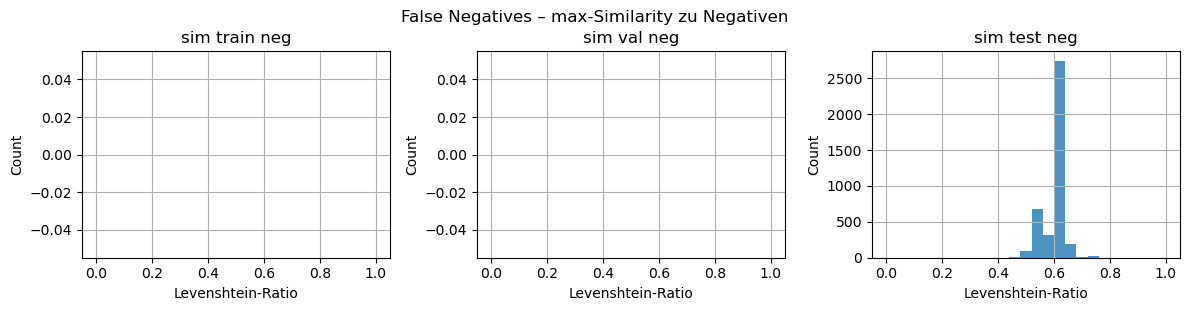

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) False Positives laden
fp = pd.read_csv("../../results/false_negatives_v2.csv", sep="\t")

# 2) Splits laden & echte Positive (Binding==1) pro Split sammeln
BASE = "../../../../data/splitted_datasets/allele/beta/new"
train = pd.read_csv(f"{BASE}/train.tsv",      sep="\t", dtype=str)
val   = pd.read_csv(f"{BASE}/validation.tsv", sep="\t", dtype=str)
test  = pd.read_csv(f"{BASE}/test.tsv",       sep="\t", dtype=str)
for df in (train, val, test):
    df["Binding"] = df["Binding"].astype(int)

neg_train = train [train["Binding"]==0].groupby("TRB_CDR3")["Epitope"].apply(set)
neg_val   = val   [val  ["Binding"]==0].groupby("TRB_CDR3")["Epitope"].apply(set)
neg_test  = test  [test ["Binding"]==0].groupby("TRB_CDR3")["Epitope"].apply(set)

# 3) Levenshtein-Ratio
def levenshtein(a, b):
    if len(a) < len(b): return levenshtein(b, a)
    prev = list(range(len(b)+1))
    for i, ca in enumerate(a,1):
        curr = [i]
        for j, cb in enumerate(b,1):
            curr.append(min(prev[j]+1, curr[j-1]+1, prev[j-1]+(ca!=cb)))
        prev = curr
    return prev[-1]

def ratio(a,b):
    d = levenshtein(a,b)
    return (len(a)+len(b)-d)/(len(a)+len(b))

# 4) Funktion: max‐Similarity gegenüber einem bestimmten Negativen-Set
def max_sim_to_negsame(row, neg_dict):
    tcr = row["TRB_CDR3"]
    epi = row["Epitope"]
    neps = neg_dict.get(tcr, ())
    if not neps:
        return np.nan
    return max(ratio(epi, neg) for neg in neps)

# 5) Drei neue Spalten berechnen
fp["sim_train_neg"] = fp.apply(lambda r: max_sim_to_negsame(r, neg_train.to_dict()), axis=1)
fp["sim_val_neg"]   = fp.apply(lambda r: max_sim_to_negsame(r, neg_val.to_dict()),   axis=1)
fp["sim_test_neg"]  = fp.apply(lambda r: max_sim_to_negsame(r, neg_test.to_dict()),  axis=1)

# 6) Statistiken drucken
print("=== False Negatives: max‐Similarity zu Negativen pro Split ===")
for col in ["sim_train_neg","sim_val_neg","sim_test_neg"]:
    print(f"\n{col}:\n{fp[col].describe()}")

# 7) Histogramme plotten
plt.figure(figsize=(12,3))
for i, col in enumerate(["sim_train_neg","sim_val_neg","sim_test_neg"], 1):
    plt.subplot(1,3,i)
    fp[col].hist(bins=25, range=(0,1), alpha=0.8)
    plt.title(col.replace("_"," "))
    plt.xlabel("Levenshtein-Ratio")
    plt.ylabel("Count")
plt.tight_layout()
plt.suptitle("False Negatives – max‐Similarity zu Negativen", y=1.02)
plt.show()


In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# CSV einlesen
fn = pd.read_csv("../../results/false_negatives_v2.csv", sep="\t")

# Nur TPP1-Fehlklassifikationen
fn_tpp1 = fn[fn["task"] == "TPP1"].copy()
print(f"Anzahl TPP1 False Negatives: {len(fn_tpp1)}")

# Nur TPP2-Fehlklassifikationen
fn_tpp2 = fn[fn["task"] == "TPP2"].copy()
print(f"Anzahl TPP2 False Negatives: {len(fn_tpp2)}")

# Nur TPP3-Fehlklassifikationen
fn_tpp3 = fn[fn["task"] == "TPP3"].copy()
print(f"Anzahl TPP3 False Negatives: {len(fn_tpp3)}")

# Nur TPP4-Fehlklassifikationen
fn_tpp4 = fn[fn["task"] == "TPP4"].copy()
print(f"Anzahl TPP4 False Negatives: {len(fn_tpp4)}")

# Top Epitope bei FPs
top_epitopes = fp_tpp2["Epitope"].value_counts().head(10)
print("\nTop Epitope unter TPP2-False-Negatives:\n", top_epitopes)


Anzahl TPP1 False Negatives: 527
Anzahl TPP2 False Negatives: 3555
Anzahl TPP3 False Negatives: 515
Anzahl TPP4 False Negatives: 51

Top Epitope unter TPP2-False-Negatives:
 Epitope
CINGVCWTV     2150
ELAGIGILTV    1465
GTSGSPIINR    1351
GTSGSPIVNR    1303
GLCTLVAML     1188
GILGFVFTL      868
AVFDRKSDAK     809
KRWIILGLNK     700
EIYKRWII       654
FLKEKGGL       584
Name: count, dtype: int64


In [31]:
import pandas as pd

# 1) False Negatives einlesen
fn = pd.read_csv("../../results/false_negatives_v2.csv", sep="\t", dtype=str)

# 2) Funktion zur Anzeige von Missing/Empty pro Spalte
def report_missing(df, name):
    total = len(df)
    print(f"\n== {name} ({total} Zeilen) ==")
    for col in ["TRBJ", "TRBV", "MHC"]:
        if col not in df.columns:
            print(f"Spalte {col} nicht gefunden.")
            continue
        missing = df[col].isna().sum()
        empty   = (df[col] == "").sum()
        print(f" {col}: missing={missing} ({missing/total:.2%}), empty={empty} ({empty/total:.2%})")

# 3) Reports ausgeben
report_missing(fn, "False Negatives")



== False Negatives (4648 Zeilen) ==
 TRBJ: missing=0 (0.00%), empty=0 (0.00%)
 TRBV: missing=0 (0.00%), empty=0 (0.00%)
 MHC: missing=127 (2.73%), empty=0 (0.00%)


# Vorkommenn Epiotpe und TCR von FP und FN in TN und TP

In [39]:
import pandas as pd

# --- 1) Daten einlesen ---
BASE   = "../../../../data/splitted_datasets/allele/beta/new"
train  = pd.read_csv(f"{BASE}/train.tsv",      sep="\t", dtype=str)
val    = pd.read_csv(f"{BASE}/validation.tsv", sep="\t", dtype=str)
test   = pd.read_csv(f"{BASE}/test.tsv",       sep="\t", dtype=str)
fp    = pd.read_csv("../../results/false_positives_v2.csv", sep="\t", dtype=str)
fn    = pd.read_csv("../../results/false_negatives_v2.csv", sep="\t", dtype=str)

for df in (train, val, test):
    df["Binding"] = df["Binding"].astype(int)

# --- 2) Top-10 Epitope in FPs ---
top_ep = fp["Epitope"].value_counts().head(20).index.tolist()
print("Top-20 Epitopes in False Positives:\n", top_ep)

top_ep_n = fn["Epitope"].value_counts().head(20).index.tolist()
print("Top-20 Epitopes in False Negatives:\n", top_ep_n)

# --- 3) Häufigkeiten in allen Splits zählen ---
all_splits = pd.concat([
    train.assign(split="train"),
    val  .assign(split="validation"),
    test .assign(split="test")
], ignore_index=True)

tp_counts = (all_splits
    .query("Epitope in @top_ep and Binding==1")
    .groupby("Epitope")["split"]
    .value_counts()
    .unstack(fill_value=0)
)
tn_counts = (all_splits
    .query("Epitope in @top_ep_n and Binding==0")
    .groupby("Epitope")["split"]
    .value_counts()
    .unstack(fill_value=0)
)

print("\n=== True Positives (Binding=1) counts for top-20 Epitopes ===")
print(tp_counts)

print("\n=== True Negatives (Binding=0) counts for top-20 Epitopes ===")
print(tn_counts)

# --- 4) Dasselbe für TCRs machen ---
top_tcr = fp["TRB_CDR3"].value_counts().head(20).index.tolist()
print("\nTop-20 TCRs in False Positives:\n", top_tcr)

top_tcr_n = fn["TRB_CDR3"].value_counts().head(20).index.tolist()
print("\nTop-20 TCRs in False Negatives:\n", top_tcr_n)

tp_tcr = (all_splits
    .query("TRB_CDR3 in @top_tcr and Binding==1")
    .groupby("TRB_CDR3")["split"]
    .value_counts()
    .unstack(fill_value=0)
)
tn_tcr = (all_splits
    .query("TRB_CDR3 in @top_tcr_n and Binding==0")
    .groupby("TRB_CDR3")["split"]
    .value_counts()
    .unstack(fill_value=0)
)

print("\n=== True Positives counts for top-20 TCRs ===")
print(tp_tcr)

print("\n=== True Negatives counts for top-20 TCRs ===")
print(tn_tcr)


Top-20 Epitopes in False Positives:
 ['CINGVCWTV', 'ELAGIGILTV', 'GTSGSPIINR', 'GTSGSPIVNR', 'GLCTLVAML', 'LLLGIGILV', 'GILGFVFTL', 'AVFDRKSDAK', 'KRWIILGLNK', 'EIYKRWII', 'FLKEKGGL', 'GTSGSPIIDK', 'RAKFKQLL', 'NLVPMVATV', 'IVTDFSVIK', 'KRKGGIGGY', 'KRWIIMGLNK', 'TLNAWVKVV', 'SLYNTVATL', 'TPRVTGGGAM']
Top-20 Epitopes in False Negatives:
 ['KLGGALQAK', 'ELAGIGILTV', 'NLVPMVATV', 'GLCTLVAML', 'LLWNGPMAV', 'KAFSPEVIPMF', 'ATDALMTGF', 'YLQPRTFLL', 'KRWIILGLNK', 'RLRAEAQVK', 'KSKRTPMGF', 'QYIKWPWYI', 'HPVTKYIM', 'GPRLGVRAT', 'AVFDRKSDAK', 'GPGHKARVL', 'YSEHPTFTSQY', 'SLFNTVATLY', 'RLRPGGKKK', 'LLLGIGILV']

=== True Positives (Binding=1) counts for top-20 Epitopes ===
split       test  train  validation
Epitope                            
AVFDRKSDAK   317    373        1258
CINGVCWTV    254     85          24
EIYKRWII     140     35           1
ELAGIGILTV  1092    537         376
FLKEKGGL     139      9           1
GILGFVFTL    231   4963        1292
GLCTLVAML    349   7041         127
GTSGS

In [40]:
import pandas as pd

# 1) Splits + FP & FN einlesen
BASE  = "../../../../data/splitted_datasets/allele/beta/new"
train = pd.read_csv(f"{BASE}/train.tsv",      sep="\t", dtype=str).assign(split="train")
val   = pd.read_csv(f"{BASE}/validation.tsv", sep="\t", dtype=str).assign(split="validation")
test  = pd.read_csv(f"{BASE}/test.tsv",       sep="\t", dtype=str).assign(split="test")

train["Binding"] = train["Binding"].astype(int)
val  ["Binding"] = val  ["Binding"].astype(int)
test ["Binding"] = test ["Binding"].astype(int)

fp = pd.read_csv("../../results/false_positives_v2.csv", sep="\t", dtype=str)
fn = pd.read_csv("../../results/false_negatives_v2.csv", sep="\t", dtype=str)

# 2) Top-20 TCRs in FP bzw. FN
top_tcr_fp = fp["TRB_CDR3"].value_counts().head(20).index.tolist()
top_tcr_fn = fn["TRB_CDR3"].value_counts().head(20).index.tolist()

print("Top-20 TCRs in False Positives:\n", top_tcr_fp, "\n")
print("Top-20 TCRs in False Negatives:\n", top_tcr_fn, "\n")

# 3) Alle Splits zusammenführen
all_splits = pd.concat([train, val, test], ignore_index=True)

# 4) True Positives counts für TCRs aus FP
tp_tcr = (
    all_splits
      .query("TRB_CDR3 in @top_tcr_fp and Binding==1")
      .groupby("TRB_CDR3")["split"]
      .value_counts()
      .unstack(fill_value=0)
)

# 5) True Negatives counts für TCRs aus FN
tn_tcr = (
    all_splits
      .query("TRB_CDR3 in @top_tcr_fn and Binding==0")
      .groupby("TRB_CDR3")["split"]
      .value_counts()
      .unstack(fill_value=0)
)

print("=== True Positives counts for top-20 FP-TCRs ===")
print(tp_tcr.to_string(), "\n")

print("=== True Negatives counts for top-20 FN-TCRs ===")
print(tn_tcr.to_string())


Top-20 TCRs in False Positives:
 ['CASSRDTVNTEAFF', 'CATSDNNVWFSEQFF', 'CASSPSGLAGSNLGNEQFF', 'CASRTRGGTLIEQYF', 'CASSLKDGFSYEQYF', 'CASSSYSGTASYEQYF', 'CASSYQGTEAFF', 'CASRDSSYEQYF', 'CASSRDFVSNEQYF', 'CASSYEPGQVSHYSNQPQHF', 'CASSFDGVYEQYF', 'CASSFEAGQGFFSNQPQHF', 'CASSLGQGLLYGYTF', 'CASSFVPGPQETQYF', 'CASSPRGDGWEQYF', 'CASIRGQGVDTEAFF', 'CASSSTSGAQGDTQYF', 'CASSLGRAGYGETQYF', 'CASSLGAGGGSYEQYF', 'CASSLQPSGTSFYNEQFF'] 

Top-20 TCRs in False Negatives:
 ['CASTGSYGYTF', 'CASSPDRESNTGELFF', 'CASSGTDYGYTF', 'CASSSTGGGEKDQPQHF', 'CASSAGTEFDSNQPQHF', 'CASSYSIRRGVNEQFF', 'CSVDSKGDWGASNTEAFF', 'CSVELGVAGVYEQYF', 'CSARDLEVLSYEQYF', 'CASSQDRTSGRTRELFF', 'CASSANPGDSSNEKLFF', 'CASSQGGNEQFF', 'CASSHLDRGGTGELFF', 'CASSLGLAGVNEQFF', 'CARRESNIQYF', 'CASSLGLEGEQYF', 'CATSDDGTPNNEQFF', 'CASSLGGNEQFF', 'CASSADRGDTDTQYF', 'CASSELGQLNEQFF'] 

=== True Positives counts for top-20 FP-TCRs ===
split                 test
TRB_CDR3                  
CASIRGQGVDTEAFF          1
CASRDSSYEQYF             2
CASRTRGG